# 第3章 リサンプリング

## 3.1  クロスバリデーション

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [6]:
pip install japanize_matplotlib

In [7]:
def cv_linear(X,y,K):
    n=len(y);m=int(n/K)
    S=0
    for j in range(K):
        test=list(range(j*m,(j+1)*m)) # テストデータの添え字 
        train=list(set(range(n))-set(test))     # 訓練データの添え字
        beta=np.linalg.inv(X[train,].T@X[train,])@X[train,].T@y[train]
        e=y[test]-X[test,]@beta
        S=S+np.linalg.norm(e)**2
    return S/n

In [8]:
n=100;p=5
X=randn(n,p)
X=np.insert(X, 0, 1, axis=1)

In [9]:
beta=randn(p+1)
beta[[1,2]]=0
y=X@beta+randn(n)

In [10]:
cv_linear(X[:,[0,3,4,5]],y,10)

1.2392322156874365

In [11]:
cv_linear(X,y,10)

1.2835848110575439

In [12]:
n=100;p=5
X=randn(n,p)
X=np.insert(X, 0, 1, axis=1)
beta=randn(p+1);beta[[1,2]]=0

In [13]:
U=[]; V=[] 
for j in range(100):
    y=X@beta+randn(n)
    U.append(cv_linear(X[:,[0,3,4,5]],y,10))
    V.append(cv_linear(X,y,10))

Text(0.5, 1.0, ' 変数を多く選びすぎて過学習')

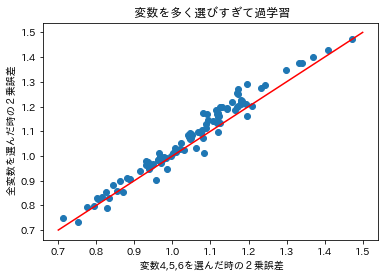

In [14]:
x_seq=np.linspace(0.7,1.5,100)
y=x_seq
plt.plot(x_seq,y,c="red")
plt.scatter(U,V)
plt.xlabel(" 変数4,5,6を選んだ時の２乗誤差")
plt.ylabel(" 全変数を選んだ時の２乗誤差")
plt.title(" 変数を多く選びすぎて過学習")

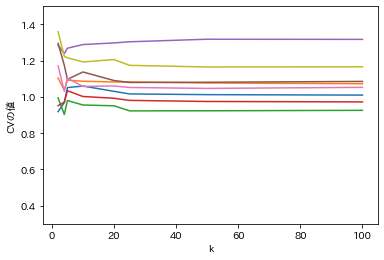

In [15]:
n=100;p=5
plt.ylim(0.3,1.5)
plt.xlabel("k")
plt.ylabel("CVの値")
for j in range(2,11,1):
    X=randn(n,p)
    X=np.insert(X, 0, 1, axis=1)
    beta=randn(p+1)
    y=X@beta+randn(n)
    U = []; V = []
    for k in range(2,n+1,1):
        if n%k==0:
            U.append(k); V.append(cv_linear(X,y,k))
    plt.plot(U,V)        

In [16]:
def knn_1(x,y,z,k):   # 再掲
    x=np.array(x)
    n,p=x.shape
    dis=np.zeros(n)
    for i in range(n):
        dis[i]=(z-x[i,]).T@(z-x[i,])
    S=np.argsort(dis)[0:k]  # 距離が近いk個のindex
    u=np.bincount(y[S])     # 度数を数える
    m = [i for i, x in enumerate(u) if x == max(u)] # 最頻値のindex
    # タイブレーキングの処理(最頻値が２個以上ある場合)
    while (len(m)>1):
        k=k-1
        S=S[0:k]
        u=np.bincount(y[S])
        m = [i for i, x in enumerate(u) if x == max(u)] # 最頻値のindex
    return m[0]
def knn(x,y,z,k):
    n=z.shape[0]
    w=np.zeros(n)
    for i in range(n):
        w[i]=knn_1(x,y,z[i,],k)
    return w

In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.target_names
x=iris.data
y=iris.target

In [18]:
n=x.shape[0]
index=np.random.choice(n, n, replace=False) # 並び替える
x=x[index,]
y=y[index]

Text(0.5, 1.0, 'CV による誤り率の評価')

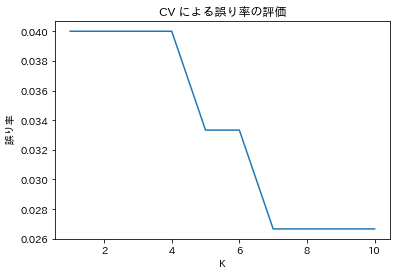

In [19]:
U = []
V = []
top_seq=list(range(0,150,15))    ## 2020-7-23 KM氏が指摘
for k in range(1,11,1):
    S=0
    for top in top_seq:
        test=list(range(top,top+15))
        train=list(set(range(150))-set(test))
        knn_ans=knn(x[train,],y[train],x[test,],k=k)
        ans=y[test]
        S=S+np.sum(knn_ans!=ans)
    S=S/n
    U.append(k)
    V.append(S)
plt.plot(U,V)
plt.xlabel("K")
plt.ylabel(" 誤り率")
plt.title("CV による誤り率の評価")

↑データによって結構かわります

## 3.2 CV fast

In [20]:
def cv_fast(X,y,k):
    n=len(y)
    m=n/k
    H=X@np.linalg.inv(X.T@X)@X.T
    I=np.diag(np.repeat(1,n))
    e=(I-H)@y
    I=np.diag(np.repeat(1,m))
    S=0
    for j in range(k):
        test=np.arange(j*m,(j+1)*m,1,dtype=int)
        S=S+(np.linalg.inv(I-H[test,:][:,test])@e[test]).T@np.linalg.inv(I-H[test,test])@e[test]
    return S/n

In [21]:
cv_fast(x,y,10)

0.05066027652535804

In [22]:
n=1000;p=5
beta=randn(p+1)
x=randn(n,p)
X=np.insert(x, 0, 1, axis=1)

In [23]:
y=X@beta+randn(n)

In [24]:
import time

Text(0.5, 1.0, 'cv_fastとcv_linearの比較')

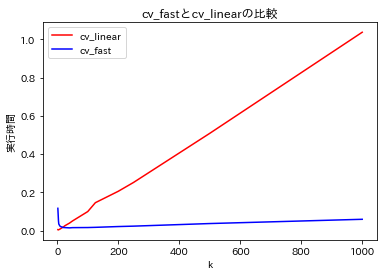

In [25]:
U_l=[]; V_l=[]; U_f=[]; V_f=[]
for k in range(2,n+1,1):
    if n%k==0:
        t1=time.time() # 処理前の時刻
        cv_linear(X,y,k)
        t2=time.time() #処理後の時刻
        U_l.append(k); V_l.append(t2-t1)
        t1=time.time() 
        cv_fast(X,y,k)
        t2=time.time() 
        U_f.append(k); V_f.append(t2-t1)
plt.plot(U_l,V_l,c="red",label="cv_linear")
plt.plot(U_f,V_f,c="blue",label="cv_fast")
plt.legend()  
plt.xlabel("k")
plt.ylabel("実行時間")
plt.title("cv_fastとcv_linearの比較")

## 3.3 ブートストラップ

In [1]:
def bt(df,f,r):
    m=df.shape[0]
    org=f(df,np.arange(0,m,1))
    u=[]
    for j in range(r):
        index=np.random.choice(m, m, replace=True) 
        u.append(f(df,index))
    return {'original':org, 'bias':np.mean(u)-org, 'stderr':np.std(u,ddof=1)}

In [31]:
Portfolio=np.loadtxt("Portfolio.csv",delimiter=",",skiprows=1)

In [35]:
def func_1(data,index):
    X=data[index,0];Y=data[index,1]
    return (np.var(Y,ddof=1)-np.var(X,ddof=1))/(np.var(X,ddof=1)+np.var(Y,ddof=1)-2*np.cov(X,Y)[0,1])

In [36]:
bt(Portfolio,func_1,1000)

{'bias': 0.006650686748271795,
 'original': 0.15166414929676297,
 'stderr': 0.189698210945925}

In [38]:
df=np.loadtxt("crime.txt",delimiter="\t")

In [39]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
X=df[:,2:4]
y=df[:,0]
reg.fit(X,y)
reg.coef_

array([11.8583308 , -5.97341169])

In [ ]:
for j in range(3):
    def func_2(data,index):
        X=data[index,2:4];y=data[index,0]
        reg.fit(X,y)
        if j==0:
            return reg.intercept_
        else:
            return reg.coef_[j-1]
    print (bt(df,func_2,1000))

In [ ]:
import statsmodels.api as sm
n=X.shape[0]
X=np.insert(X, 0, 1, axis=1)
model = sm.OLS(y,X)
res = model.fit()
print(res.summary())

In [ ]:
n=1000; p=5
X=np.insert(randn(n,p), 0, 1, axis=1)
beta=randn(p+1).reshape(-1,1)
y=X@beta+0.2*randn(n).reshape(-1,1)
y=y[:,0]
## 通常のクロスバリデーションによる方法
def cv_linear(X,y,K):
    n=len(y);m=int(n/K)
    S=0
    for j in range(K):
        test=list(range(j*m,(j+1)*m)) # テストデータの添え字 
        train=list(set(range(n))-set(test))     # 訓練データの添え字
        beta=np.linalg.inv(X[train,].T@X[train,])@X[train,].T@y[train]
        e=y[test]-X[test,]@beta
        S=S+np.linalg.norm(e)**2
    return S/n
## 公式を用いた方法
def cv_fast(X,y,k):
    n=len(y)
    m=n/k
    H=X@np.linalg.inv(X.T@X)@X.T
    I=np.diag(np.repeat(1,n))
    e=(I-H)@y
    I=np.diag(np.repeat(1,m))
    S=0
    for j in range(k):
        test=np.arange(j*m,(j+1)*m,1,dtype=int)
        S=S+(np.linalg.inv(I-H[test,test])@e[test]).T@np.linalg.inv(I-H[test,test])@e[test]
    return S/n